## Урок 4.
# Способы улучшения полученной модели.

**План занятия**

* [Теоретическая часть](#theory)
    * [Переобучение и способы борьбы с ним](#overfitting)
    * [Регуляризация](#regularization)
    * [Заполнение пропусков/выбросов](#imputer)
* [Практическая часть](#practice)
    * [LogisticRegression](#lr)
    * [Support Vector Machine](#svm)
    * [XGBoost](#xgb)
    * [CatBoost](#cat)
        * [Модель, полученная на предыдущем уроке](#model_from_prev_lesson)
        * [Снижение степени переобучения](#lowering_overfitting)
        * [Подбор оптимального размера выборки, кривая обучения](#learning_curve)
        * [Выбор порога вероятности для определения класса](#threshold_calibration)
        * [Важность признаков](#feature_importances)  
        * [Финальная модель](#final_model)
        * [Сохранение финальной модели](#final_model_saving)
* [Обобщение работы с новой задачей](#summary)

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

### Переобучение и способы борьбы с ним<a class="anchor" id="overfitting"></a>

**Переобучение**

Нежелательное явление, возникающее при решении задач обучения по прецедентам, когда вероятность ошибки обученного алгоритма на объектах тестовой выборки оказывается существенно выше, чем средняя ошибка на обучающей выборке. Переобучение возникает при использовании избыточно сложных моделей.

<img src="img/overfitting.svg" alt="Drawing" style="width: 500px;">

**Способы борьбы с переобучением**

1. Обнаружить переобучение:
    * отложенная выборка
    * кросс-валидация
    * меры сложности модели
2. Взять больше данных
3. Взять меньше признаков
4. Выбрать более простую модель
5. Регуляризация

### Регуляризация<a class="anchor" id="regularization"></a>

Метод регуляризации заключается в "штрафовании" модели за слишком большие веса путем добавления нового члена к ошибке:

$$Q(w, X) + \lambda ||w||^{2} \rightarrow \underset{w}{\text{min}}.$$

добавленный член $\lambda ||w||^{2}$ - **квадратичный регуляризатор**, который представляет собой $L_{2}$-норму вектора весов, то есть сумму квадратов весов $\sum^{d}_{j=1}w_{j}^{2}$, коэффициент $\lambda$ при нем - коэффициент регуляризации.

Чем больше его $\lambda$, тем меньшая сложность модели будет получаться в процессе такого обучения.
    - Если увеличивать его, в какой-то момент оптимальным для модели окажется зануление всех весов
    - А при слишком низких его значениях появляется вероятность чрезмерного усложнения модели и переобучения
    - Подбираем по кросс-валидации

По сути, смысл регуляризации заключается в минимизации функционала ошибки с ограничением весов.

$$\begin{cases} Q(w, X) \rightarrow min \\ ||w||^2 \leq C \end{cases}$$

**L1-регуляризация** (lasso, регуляризация через манхэттенское расстояние)

$\large L_1 = \sum_{i=1} |(y_i - \widehat{y_i})| + \lambda\sum_{j=1} |w_j|$

**L2-регуляризация** (ridge, регуляризация Тихонова)

$\large L_2 = \sum_{i=1} (y_i - \widehat{y_i})^2 + \lambda\sum_{j=1} w_j^2$

**Метод опорных векторов**: kernels
Ядро - функция представимая в виде скалярного произведения в некотором пространстве.
https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem12_linear.pdf

<img src="img/svm_space.png" width=500px>

Можно не делать явные преобразования признаков, а вместо скалярного произведения использовать функцию K.
$$
\begin{eqnarray}
x \rightarrow \phi(x) \\
w \rightarrow \phi(w)
\nonumber
\end{eqnarray}
\qquad \Rightarrow \langle w, x \rangle \rightarrow \langle \phi(w), \phi(x) \rangle
 $$

<img src="img/svm-kernel.png">

## <center>Практическая часть<a class="anchor" id="practice"></a><center>

**Подключение библиотек и скриптов**

In [52]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
import xgboost as xgb
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [53]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [54]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [55]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [56]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    #Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [57]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [58]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [59]:
DATA_ROOT = Path('./data/training_project/')
MODELS_PATH = Path('./models/')

# input
DATASET_PATH = DATA_ROOT / 'training_project_data.csv'
PREP_DATASET_PATH = DATA_ROOT / 'training_project_data_prep.csv'

# output
TRAIN_FULL_PATH = DATA_ROOT / 'training_project_train_full.csv'
TRAIN_PART_PATH = DATA_ROOT / 'training_project_train_part_b.csv'
TEST_PART_PATH = DATA_ROOT / 'training_project_test_part.csv'

SCALER_FILE_PATH = MODELS_PATH / 'scaler.pkl'
MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

### Загрузка подготовленных датасетов<a class="anchor" id="data_loading"></a>

**Загрузка данных**

In [60]:
df = pd.read_csv(TRAIN_FULL_PATH)
df_train = pd.read_csv(TRAIN_PART_PATH)
df_test = pd.read_csv(TEST_PART_PATH)

**Выделение признакового описания и целевой переменной**

In [61]:
TARGET_NAME = 'NEXT_MONTH_DEFAULT'
BASE_FEATURE_NAMES = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                      'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                      'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

NUM_FEATURE_NAMES = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                     'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

CAT_FEATURE_NAMES = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [62]:
X = df.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y = df[TARGET_NAME]

X_train = df_train.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_train = df_train[TARGET_NAME]

X_test = df_test.drop(columns=[TARGET_NAME] + CAT_FEATURE_NAMES)
y_test = df_test[TARGET_NAME]

In [63]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

0    5464
1    5464
Name: NEXT_MONTH_DEFAULT, dtype: int64

In [64]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

### Заполнение пропусков/выбросов<a class='anchor' id='imputer'>

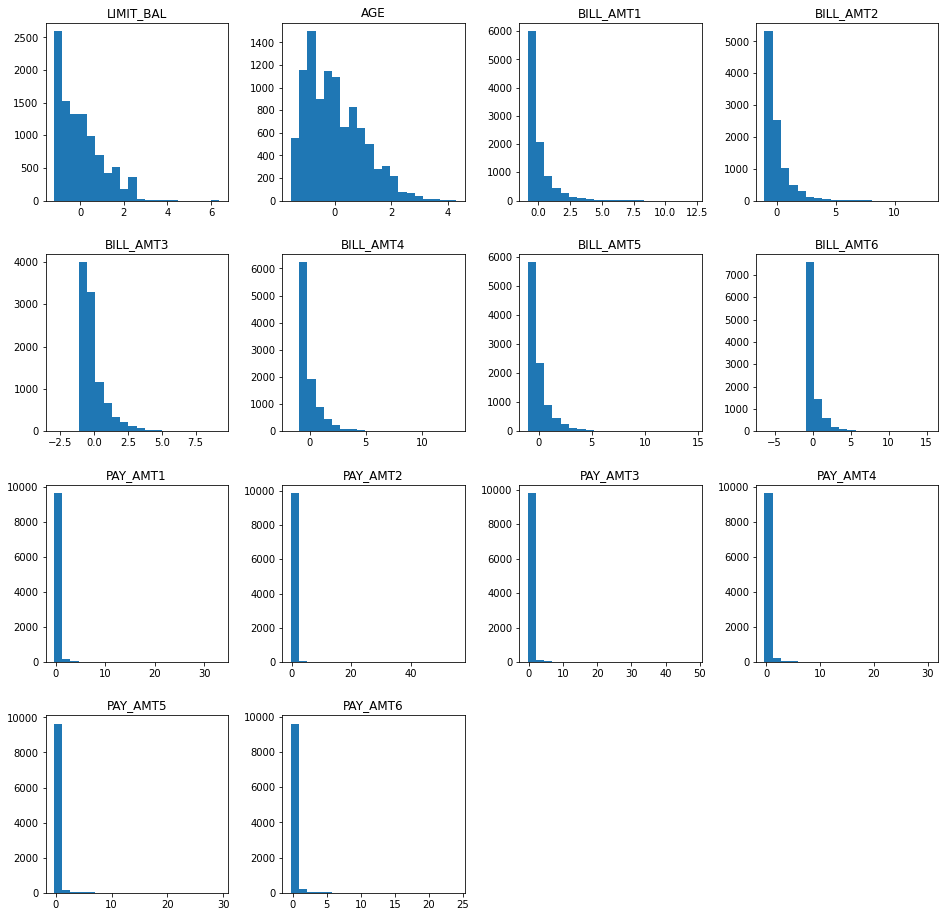

In [14]:
df[NUM_FEATURE_NAMES].hist(figsize=(16, 16), bins=20, grid=False);

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


#Коэффициент детерминации (R^2 — R-квадрат) 
#— это доля дисперсии зависимой переменной, объясняемая рассматриваемой моделью зависимости,
#то есть объясняющими переменными. 

def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()] # we have there some values
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")
    

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [66]:
df_copy = df.copy()
df_test_copy = df_test.copy()

In [67]:
df_copy.isna().sum().sum()

0

**BILL_AMT_1**

In [68]:
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'BILL_AMT1'
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

56

In [69]:
%%time
bill_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9760594593310188
r2 на test: 0.9217343945745702
Wall time: 5.1 s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [70]:
df_copy[feature_name].isna().sum()

0

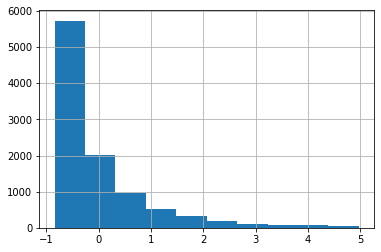

In [71]:
df_copy[feature_name].hist();

**PAY_AMT1**

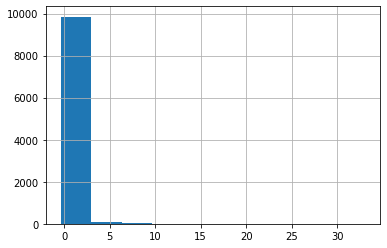

In [72]:
feature_name = 'PAY_AMT1'
df_copy[feature_name].hist();

In [73]:
df_copy = preprocess_outlier(df_copy, feature_name, threshold=5)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=5)

df_copy[feature_name].isna().sum()

68

In [74]:
pay_amt1_predictor, df_copy = imputer_rfr(df_copy, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9171075258863196
r2 на test: 0.7495696788213069


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
df_copy[feature_name].isna().sum()

0

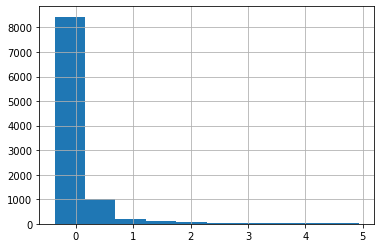

In [75]:
df_copy[feature_name].hist();

## Logistic Regression <a class='anchor' id='lr'>

In [81]:
model_lr = LogisticRegression(C=0.01, # 1/lamda
                              max_iter=10
                              )
model_lr.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr, X_train_balanced, X_test, y_train_balanced, y_test)
model_lr.intercept_, model_lr.coef_.mean()

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.85      0.76      5464
           1       0.81      0.61      0.69      5464

    accuracy                           0.73     10928
   macro avg       0.74      0.73      0.73     10928
weighted avg       0.74      0.73      0.73     10928

TEST

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2341
           1       0.55      0.53      0.54       659

    accuracy                           0.80      3000
   macro avg       0.71      0.70      0.71      3000
weighted avg       0.80      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2054  287
1                    309  350


(array([1.92571895]), -0.1251021284559743)

In [82]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [86]:
%%time
model_lr_cv = LogisticRegressionCV(max_iter=4,
                                   cv=cv, Cs=[0.01, 0.001, 0.000000001], 
                                   )
model_lr_cv.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_lr_cv, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.85      0.74      5464
           1       0.79      0.57      0.66      5464

    accuracy                           0.71     10928
   macro avg       0.73      0.71      0.70     10928
weighted avg       0.73      0.71      0.70     10928

TEST

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2341
           1       0.54      0.53      0.54       659

    accuracy                           0.80      3000
   macro avg       0.71      0.70      0.70      3000
weighted avg       0.80      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2048  293
1                    309  350
Wall time: 103 ms


In [87]:
model_lr_cv.Cs_

array([1.e-02, 1.e-03, 1.e-09])

In [88]:
model_lr_cv.C_

array([0.01])

## Support Vector Machine <a class='anchor' id='svm'>

In [90]:
%%time
model_svc = SVC(
                kernel='rbf'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      5464
           1       0.86      0.70      0.77      5464

    accuracy                           0.79     10928
   macro avg       0.80      0.79      0.79     10928
weighted avg       0.80      0.79      0.79     10928

TEST

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      2341
           1       0.57      0.47      0.52       659

    accuracy                           0.80      3000
   macro avg       0.71      0.69      0.70      3000
weighted avg       0.79      0.80      0.80      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2102  239
1                    347  312
Wall time: 14.7 s


In [89]:
%%time
model_svc = SVC(C=0.05,
                kernel='rbf'
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.66      0.87      0.75      5464
           1       0.81      0.55      0.66      5464

    accuracy                           0.71     10928
   macro avg       0.74      0.71      0.71     10928
weighted avg       0.74      0.71      0.71     10928

TEST

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2341
           1       0.55      0.48      0.51       659

    accuracy                           0.80      3000
   macro avg       0.70      0.69      0.69      3000
weighted avg       0.79      0.80      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   2082  259
1                    342  317
Wall time: 19.4 s


In [91]:
%%time
model_svc = SVC(C=0.1,
                kernel='poly',
                degree=3
                )
model_svc.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_svc, X_train_balanced, X_test, y_train_balanced, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.84      0.76      5464
           1       0.80      0.64      0.71      5464

    accuracy                           0.74     10928
   macro avg       0.75      0.74      0.74     10928
weighted avg       0.75      0.74      0.74     10928

TEST

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2341
           1       0.50      0.54      0.52       659

    accuracy                           0.78      3000
   macro avg       0.68      0.69      0.69      3000
weighted avg       0.79      0.78      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1988  353
1                    305  354
Wall time: 10.6 s


## XGBoost<a class='anchor' id='xgb'>

In [92]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[18:55:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      5464
           1       0.79      0.66      0.72      5464

    accuracy                           0.74     10928
   macro avg       0.75      0.74      0.74     10928
weighted avg       0.75      0.74      0.74     10928

TEST

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2341
           1       0.50      0.58      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.79      0.78      0.79      3000

CONFUSION MATRIX

col_0

In [93]:
params = {
    'reg_lambda': [0.2, 0.5, 0.9, 1.3, 1.9, 3, 5, 10]
}

In [94]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [95]:
%%time
grid_search = GridSearchCV(param_grid=params, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)
display(grid_search.best_params_, grid_search.best_score_)

[18:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

{'reg_lambda': 1.3}

0.7151678681416852

Wall time: 4.04 s


In [97]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=1.3
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[18:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      5464
           1       0.79      0.66      0.72      5464

    accuracy                           0.74     10928
   macro avg       0.75      0.74      0.74     10928
weighted avg       0.75      0.74      0.74     10928

TEST

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2341
           1       0.50      0.58      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.79      0.78      0.79      3000

CONFUSION MATRIX

col_0

In [96]:
model_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=10
                             )
model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

[18:56:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      5464
           1       0.78      0.66      0.72      5464

    accuracy                           0.74     10928
   macro avg       0.75      0.74      0.74     10928
weighted avg       0.75      0.74      0.74     10928

TEST

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2341
           1       0.51      0.58      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.78      0.79      3000

CONFUSION MATRIX

col_0

### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

In [98]:
import inspect
print(inspect.getsource(show_learning_curve_plot))

def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    #Determines cross-validated training and test scores for different training set sizes.
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes,

In [99]:
np.linspace(.1, 1.0, 5)

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

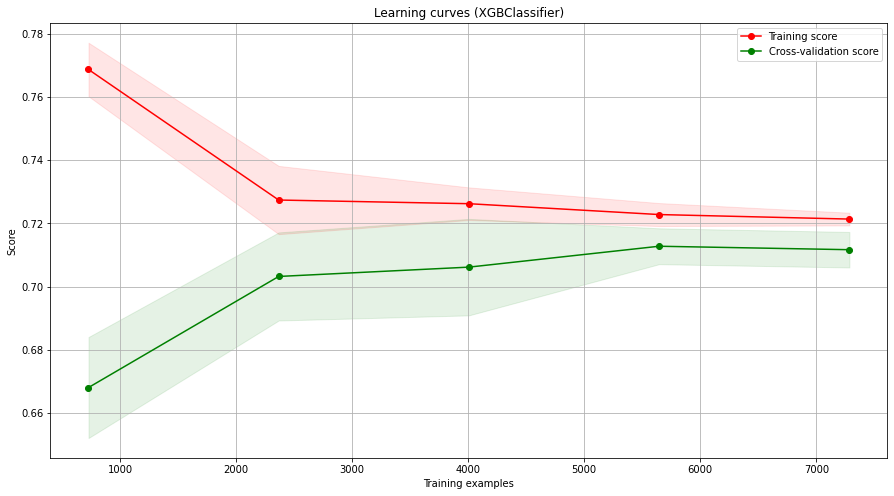

In [100]:
show_learning_curve_plot(model_xgb, X_train_balanced, y_train_balanced)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

In [101]:
y_test_pred_probs = model_xgb.predict_proba(X_test)
y_test_pred_probs

array([[0.6765007 , 0.3234993 ],
       [0.6559421 , 0.34405792],
       [0.6127682 , 0.38723183],
       ...,
       [0.70669764, 0.29330236],
       [0.2073052 , 0.7926948 ],
       [0.7335191 , 0.26648095]], dtype=float32)

In [102]:
threshold =0.6
# y_test_pred_probs[:, 1], y_test
precision_score(y_test, list(map(int, y_test_pred_probs[:, 1] > threshold)))


0.6052631578947368

In [43]:
print(inspect.getsource(show_proba_calibration_plots))

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, labe

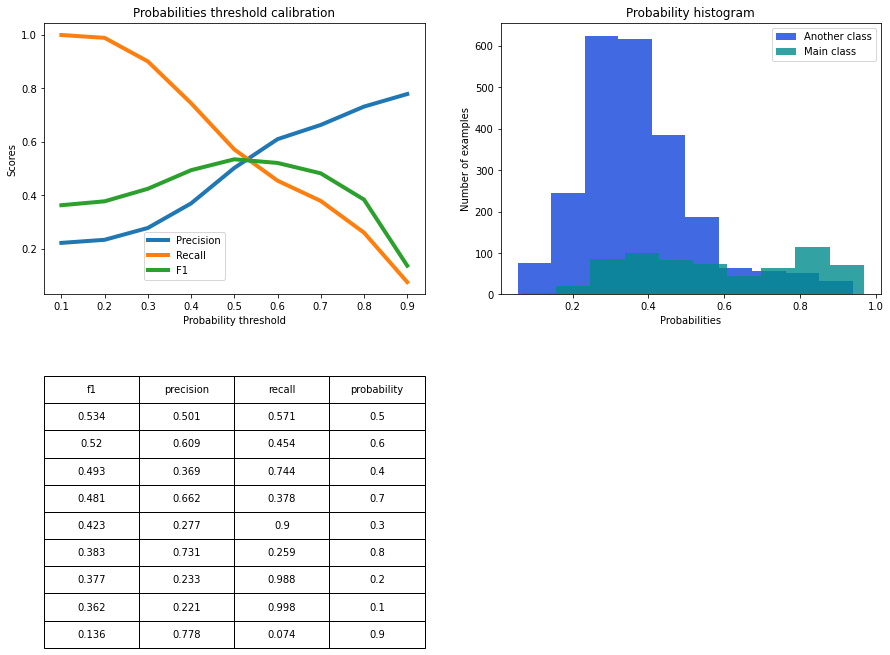

In [44]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

In [103]:
print(inspect.getsource(show_feature_importances))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()



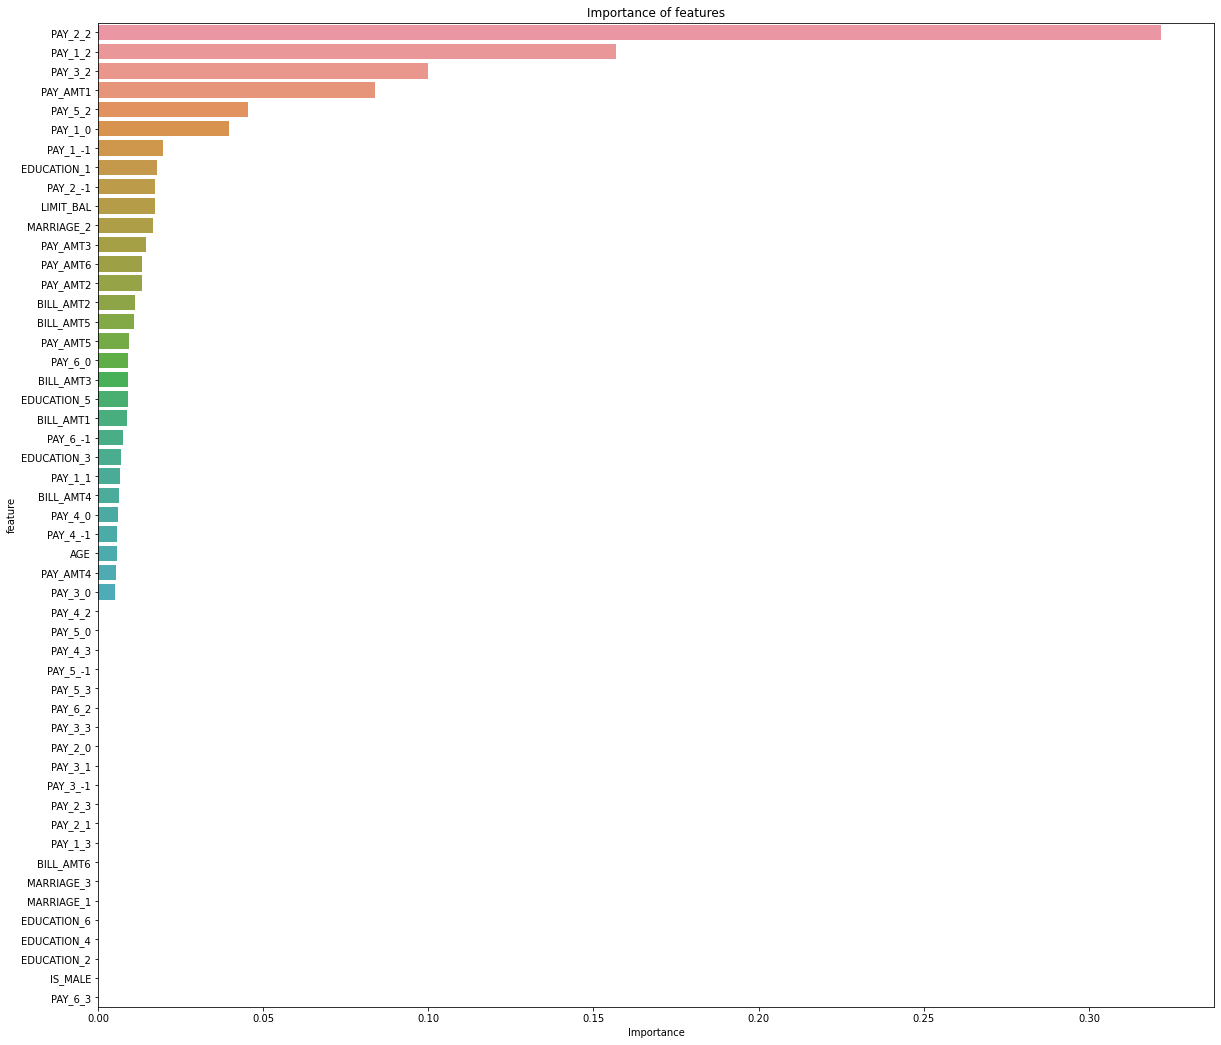

In [104]:
important_features_top = show_feature_importances(X_train_balanced.columns,
                                                  model_xgb.feature_importances_, get_top=19)

In [105]:
important_features_top

['PAY_2_2',
 'PAY_1_2',
 'PAY_3_2',
 'PAY_AMT1',
 'PAY_5_2',
 'PAY_1_0',
 'PAY_1_-1',
 'EDUCATION_1',
 'PAY_2_-1',
 'LIMIT_BAL',
 'MARRIAGE_2',
 'PAY_AMT3',
 'PAY_AMT6',
 'PAY_AMT2',
 'BILL_AMT2',
 'BILL_AMT5',
 'PAY_AMT5',
 'PAY_6_0',
 'BILL_AMT3']

### Финальная модель<a class="anchor" id="final_model"></a>

In [106]:
final_xgb = xgb.XGBClassifier(random_state=21, 
                              max_depth=1, 
                              reg_lambda=10
                              )
final_xgb.fit(X_train_balanced[important_features_top], y_train_balanced)

evaluate_preds(final_xgb,
               X_train_balanced[important_features_top],
               X_test[important_features_top],
               y_train_balanced,
               y_test)

[19:26:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      5464
           1       0.78      0.67      0.72      5464

    accuracy                           0.74     10928
   macro avg       0.74      0.74      0.74     10928
weighted avg       0.74      0.74      0.74     10928

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      2341
           1       0.50      0.59      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.78      0.79      3000

CONFUSION MATRIX

col_0

### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [129]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_xgb, file)

## Catboost<a class='anchor' id='cat'>

In [112]:
X = df[BASE_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train = df_train[BASE_FEATURE_NAMES]
y_train = df_train[TARGET_NAME]

X_test = df_test[BASE_FEATURE_NAMES]
y_test = df_test[TARGET_NAME]

### Модель, полученная на предыдущем уроке<a class="anchor" id="model_from_prev_lesson"></a>

In [113]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

3.5572916666666665

In [114]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

In [111]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=7)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      5464
           1       0.52      0.67      0.58      1536

    accuracy                           0.79      7000
   macro avg       0.71      0.75      0.72      7000
weighted avg       0.81      0.79      0.80      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2341
           1       0.50      0.59      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.80      0.78      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1944  397
1                    267  392
Wall time: 6.36 s


### Снижение степени переобучения<a class="anchor" id="lowering_overfitting"></a>

In [115]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7, 
#                                 l2_leaf_reg=.5,
                                reg_lambda=0.5
                                )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      5464
           1       0.52      0.61      0.56      1536

    accuracy                           0.79      7000
   macro avg       0.70      0.73      0.71      7000
weighted avg       0.80      0.79      0.80      7000

TEST

              precision    recall  f1-score   support

           0       0.87      0.85      0.86      2341
           1       0.51      0.56      0.54       659

    accuracy                           0.79      3000
   macro avg       0.69      0.71      0.70      3000
weighted avg       0.79      0.79      0.79      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1985  356
1                    287  372


In [116]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [117]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=7)

In [118]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [119]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6708745648
bestIteration = 45

0:	loss: 0.6708746	best: 0.6708746 (0)	total: 3.95s	remaining: 3m 13s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6745270821
bestIteration = 0

1:	loss: 0.6745271	best: 0.6745271 (1)	total: 5.09s	remaining: 2m 2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6745270821
bestIteration = 0

2:	loss: 0.6745271	best: 0.6745271 (1)	total: 5.94s	remaining: 1m 33s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6745270821
bestIteration = 0

3:	loss: 0.6745271	best: 0.6745271 (1)	total: 6.94s	remaining: 1m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6745270821
bestIteration = 0

4:	loss: 0.6745271	best: 0.6745271 (1)	total: 7.86s	remaining: 1m 10s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6745270821
bestIteration = 0

5:	loss: 0.6745271	best: 0.6745271 (1)	total: 8.77s	remaining:

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6688457315
bestIteration = 19

49:	loss: 0.6688457	best: 0.6749100 (43)	total: 1m 20s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (20 iterations wait)


In [120]:
grid_search

{'params': {'l2_leaf_reg': 3.6050632911392406},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
   

In [121]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5464
           1       0.52      0.68      0.59      1536

    accuracy                           0.79      7000
   macro avg       0.71      0.75      0.73      7000
weighted avg       0.82      0.79      0.80      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      2341
           1       0.49      0.59      0.54       659

    accuracy                           0.77      3000
   macro avg       0.68      0.71      0.69      3000
weighted avg       0.79      0.77      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1927  414
1                    267  392
Wall time: 71.3 ms


### Подбор оптимального размера выборки, кривая обучения<a class="anchor" id="learning_curve"></a>

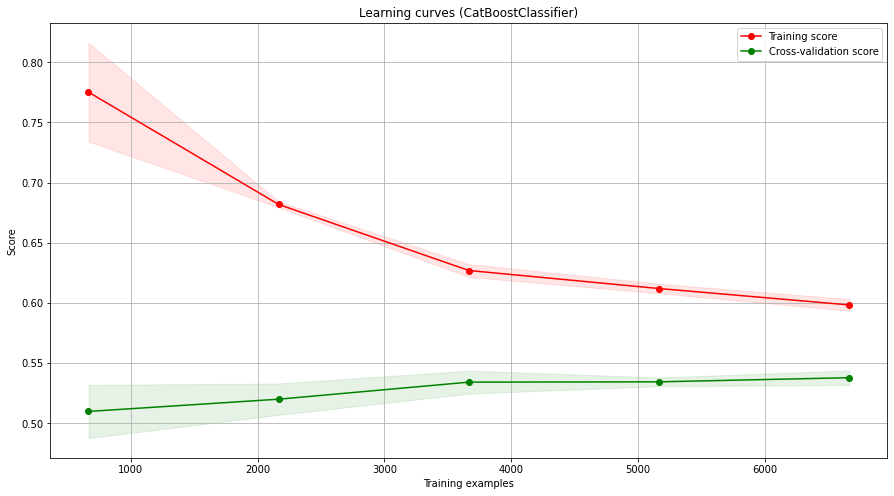

In [122]:
show_learning_curve_plot(model, X, y)

### Выбор порога вероятности для определения класса<a class="anchor" id="threshold_calibration"></a>

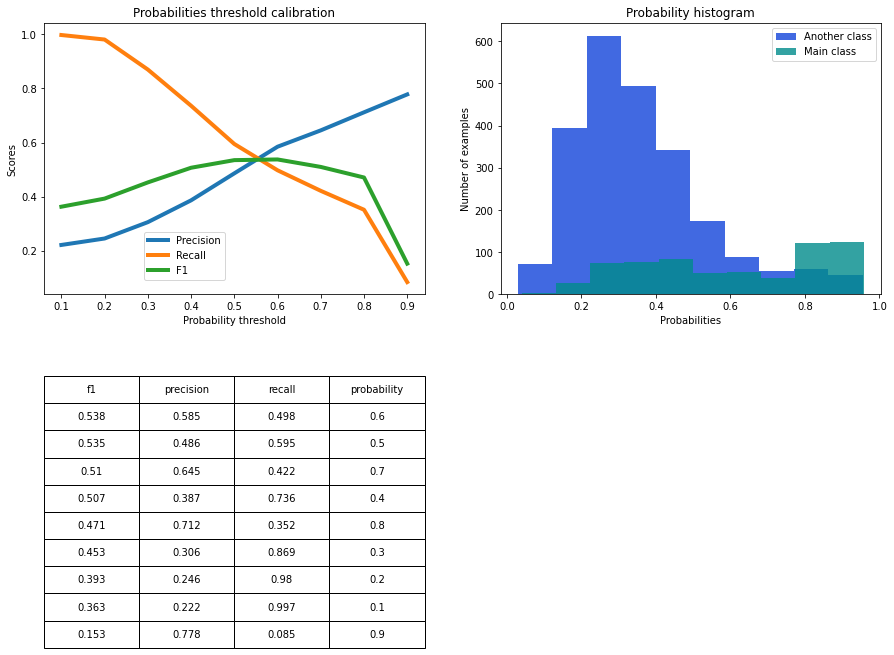

In [123]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Важность признаков<a class="anchor" id="feature_importances"></a>

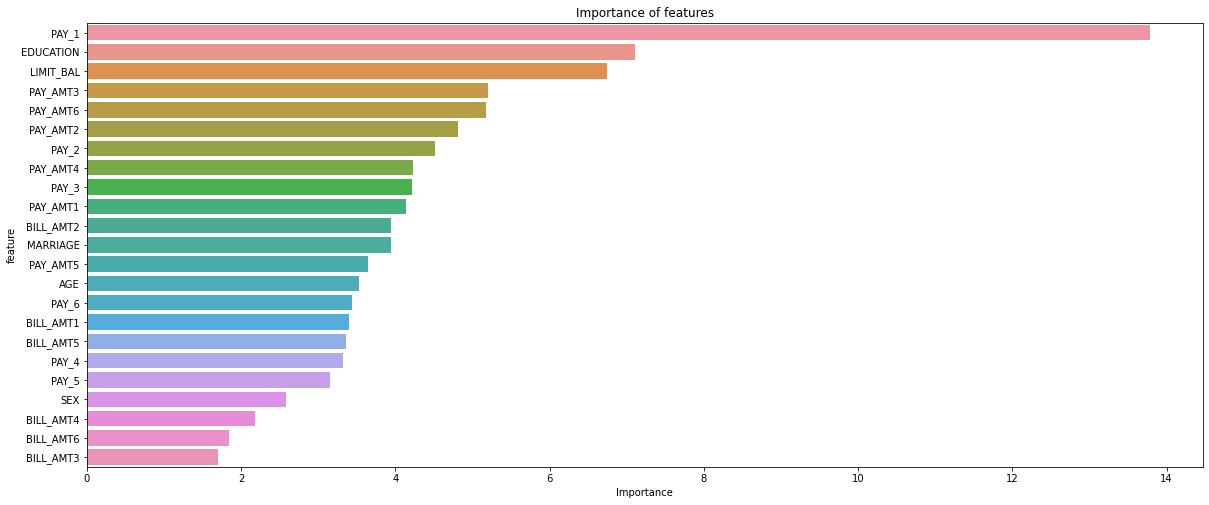

In [124]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [125]:
important_features_top

['PAY_1',
 'EDUCATION',
 'LIMIT_BAL',
 'PAY_AMT3',
 'PAY_AMT6',
 'PAY_AMT2',
 'PAY_2',
 'PAY_AMT4',
 'PAY_3',
 'PAY_AMT1',
 'BILL_AMT2',
 'MARRIAGE',
 'PAY_AMT5',
 'AGE',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT5',
 'PAY_4',
 'PAY_5',
 'SEX',
 'BILL_AMT4',
 'BILL_AMT6',
 'BILL_AMT3']

### Финальная модель<a class="anchor" id="final_model"></a>

In [126]:
CAT_FEATURE_NAMES

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [127]:
NEW_CAT_FEATURE_NAMES = list(set(CAT_FEATURE_NAMES).intersection(set(important_features_top)))
NEW_CAT_FEATURE_NAMES

['PAY_2',
 'PAY_6',
 'PAY_3',
 'PAY_1',
 'PAY_5',
 'SEX',
 'MARRIAGE',
 'EDUCATION',
 'PAY_4']

In [128]:
%%time

frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features':NEW_CAT_FEATURE_NAMES,
     'eval_metric':'F1',
     'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                      iterations=300,
                                      max_depth=7,
                                      reg_lambda=0.5)

final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5464
           1       0.54      0.68      0.60      1536

    accuracy                           0.80      7000
   macro avg       0.72      0.76      0.74      7000
weighted avg       0.82      0.80      0.81      7000

TEST

              precision    recall  f1-score   support

           0       0.88      0.83      0.85      2341
           1       0.50      0.58      0.54       659

    accuracy                           0.78      3000
   macro avg       0.69      0.71      0.69      3000
weighted avg       0.79      0.78      0.78      3000

CONFUSION MATRIX

col_0                  0    1
NEXT_MONTH_DEFAULT           
0                   1954  387
1                    277  382
Wall time: 13.3 s


### Сохранение финальной модели<a class="anchor" id="final_model_saving"></a>

In [ ]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Курсовой проект
Ссылка на kaggle тут: https://www.kaggle.com/c/654pds2courseproject/overview
* F1-score > 0.5 на private Leaderboard
* F1-score_1, recall_1, precision_1 > 0.5
* Решение прикреплять в ДЗ к Урок 4. Оценка и интерпретация полученной модели. Обсуждение курсового проекта.
* Указать свой ник на kaggle
_____________

# Обобщение работы с новой задачей <a class='anchor' id='summary'>
1. Получить базовое решение
    * Минимально познакомиться с данными
    * Заполнить пропуски простым методом (нулями, медиана, среднее, мода...)
    * Обучить простую модель (линейная, деревья...)
    * Посчитать метрику качества
2. EDA - Exploratory data analysis - Разведочный анализ данных
    * Изучить целевую переменную 
        * классификация - баланс классов
    * Изучить признаки
        * корреляция
        * найти проблемные признаки
        * найти пропуски
        * найти выбросы
        * сгенерировать идеи по их заполнению
    * Изучить влияние признаков на целевую переменную
        * корреляция - (Пирсона, Спирмена)
        * классификация - разделение значений в зависимости от классов
    * Продумать идеи для новых признаков (где-то их фиксировать)
3. Предобработка данных
    * Разделить данные на train и test
    * Зависит от выбранной модели
        * Стандартизация - только после разделения!
    * Заполнить пропуски
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Обработать выбросы
        1. Выкинуть эти данные
        2. Заменять разными методами (медианы, средние значения, бизнес-логика, строить модели...)
        3. Делать/не делать дополнительную фичу
        4. Ничего не делать
    * Генерация новых признаков
        1. Категориальные признаки
            a. pd.get_dummies, OneHotEncoder
            b. Feature Encoding
            c. Target Encoding
        2. Вещественные признаки
            a. Feature discretization
            b. Feature binarization
    * Оформить предобработку в класс/функции для воспроизводимости
4. Обучение и валидация моделей
    * Обучить модель на базовых гиперпараметрах
    * Вручную настраивать гиперпарметры
    * Автоматизированный выбор гиперпараметров с кросс-валидацией GridSearchCV/RandomSearchCV
    * Следить за переобучением, если оно появляется, то искать лучший параматер регуляризации
    * Посчитать метрики
5. Воспроизводимость
    * Зафиксировать результаты эксперимента
    * Сохранить модели
    * Сохранить версии библиотек

### Интересные посты!

https://medium.com/swlh/an-introduction-to-categorical-feature-encoding-in-machine-learning-cd0ca08c8232#:~:text=Categorical%20feature%20encoding%20is%20the,different%20encoding%20techniques%20are%20used.

https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e

https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9